# PART 1: Comparative EDA & Feature Engineering


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
pd.set_option('display.max_columns', None)


## 1.1. Load Data


In [ ]:
df_a_original = pd.read_csv('../datasets/Mud Pump A Data.csv', parse_dates=['Datetime'])
df_b_original = pd.read_csv('../datasets/Mud Pump B Data.csv', parse_dates=['Datetime'])
print("--- Pump A Original Data Head ---")
df_a_original.head()

/tmp/ipykernel_68374/3801660069.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_a_original = pd.read_csv('datasets/Mud Pump A Data.csv', parse_dates=['Datetime'])
/tmp/ipykernel_68374/3801660069.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_b_original = pd.read_csv('datasets/Mud Pump B Data.csv', parse_dates=['Datetime'])


--- Pump A Original Data Head ---


,Datetime,Mud Pump A,React 55 Mud Flow to Mud Pump A,MUD PUMP A SUCTION PRESS,MUD PUMP A SPEED,MUD PUMP A SPEED.1,PUM-34A- Current,Mud pump A speed,MUD PUMP A CYLINDER 2,MUD PUMP A CYLINDER 3,Mud Pump A Cylinder #1 Temperature,Mud Pump A Cylinder #2 Temperature,Mud Pump A Cylinder #3 Temperature,Mud Pump A Cylinder #4 Temperature
0,2024-09-03 00:00:00,RUN,105.13,387.84,42.00,99.40,262.89,41.45,6773.16,6795.82,62.21,52.91,59.37,57.87
1,2024-09-03 01:00:00,RUN,145.44,434.91,42.05,99.32,268.08,41.45,7006.63,7035.89,61.64,51.34,59.75,58.15
2,2024-09-03 02:00:00,RUN,140.59,424.09,41.96,99.47,265.45,41.45,6818.97,6843.67,61.43,52.12,60.37,58.98
3,2024-09-03 03:00:00,RUN,148.38,423.87,42.01,99.36,270.20,41.45,6922.45,6951.88,61.10,49.37,59.97,58.11
4,2024-09-03 04:00:00,RUN,140.21,425.91,41.95,99.50,269.51,41.45,6925.41,6958.68,61.52,50.28,61.68,58.28


## 1.2. Robust Data Cleaning (Corrected)


This is the corrected step to handle non-numeric values. Instead of guessing feature columns, we explicitly define the columns to *exclude* from numeric conversion, ensuring all true feature columns are cleaned.


In [14]:
def robust_clean_dataframe(df):
    cols_to_exclude = ['Datetime', 'Mud Pump A', 'Mud Pump B']
    
    # Identify all other columns that should be numeric.
    cols_to_clean = df.columns.difference(cols_to_exclude)
    
    print(f"Identified {len(cols_to_clean)} columns to clean.")
    for col in cols_to_clean:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
    nan_count_before = df.isnull().sum().sum()
    print(f"Total NaNs after coercion: {nan_count_before}")
    
    print("Filling NaN values using forward-fill and backward-fill...")
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    
    print("Cleaning complete.")
    return df

print("--- Cleaning Pump A Data ---")
df_a_original = robust_clean_dataframe(df_a_original)
print("\n--- Cleaning Pump B Data ---")
df_b_original = robust_clean_dataframe(df_b_original)



--- Cleaning Pump A Data ---
Identified 12 columns to clean.
Total NaNs after coercion: 3316
Filling NaN values using forward-fill and backward-fill...
Cleaning complete.

--- Cleaning Pump B Data ---
Identified 11 columns to clean.
Total NaNs after coercion: 4449
Filling NaN values using forward-fill and backward-fill...
Cleaning complete.


## 1.3. Standardize Columns for EDA


In [15]:
def standardize_columns(df, pump_prefix):
    df_clean = df.copy()
    mapping = {'MUD PUMP A SUCTION PRESS': 'Suction Pressure', 'MUD PUMP B SLEECTED PRESSURE': 'Suction Pressure', 'PUM-34A- Current': 'Current', 'Mud Pump B Current': 'Current'}
    df_clean.rename(columns=mapping, inplace=True)
    new_cols = []
    for col in df_clean.columns:
        new_name = col
        prefixes = [f"MUD PUMP {pump_prefix} ", f"Mud Pump {pump_prefix} ", f"Mud pump {pump_prefix} "]
        for p in prefixes:
            if new_name.upper().startswith(p.upper()): new_name = new_name[len(p):]
        new_name = new_name.replace("Cylinder #", "Cylinder ").strip()
        new_cols.append(new_name)
    df_clean.columns = new_cols
    df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]
    df_clean['Pump'] = f'Pump {pump_prefix}'
    return df_clean

df_a_clean = standardize_columns(df_a_original.copy(), 'A')
df_b_clean = standardize_columns(df_b_original.copy(), 'B')
common_cols = sorted(list(set(df_a_clean.columns) & set(df_b_clean.columns)))
df_combined = pd.concat([df_a_clean[common_cols], df_b_clean[common_cols]], ignore_index=True)

## 1.4. EDA: Feature History & Distributions


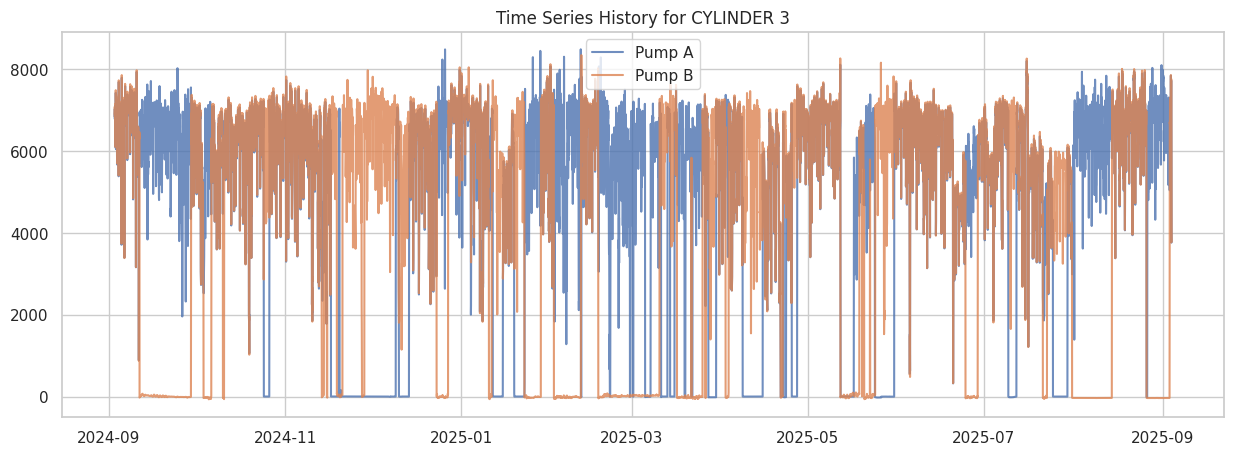

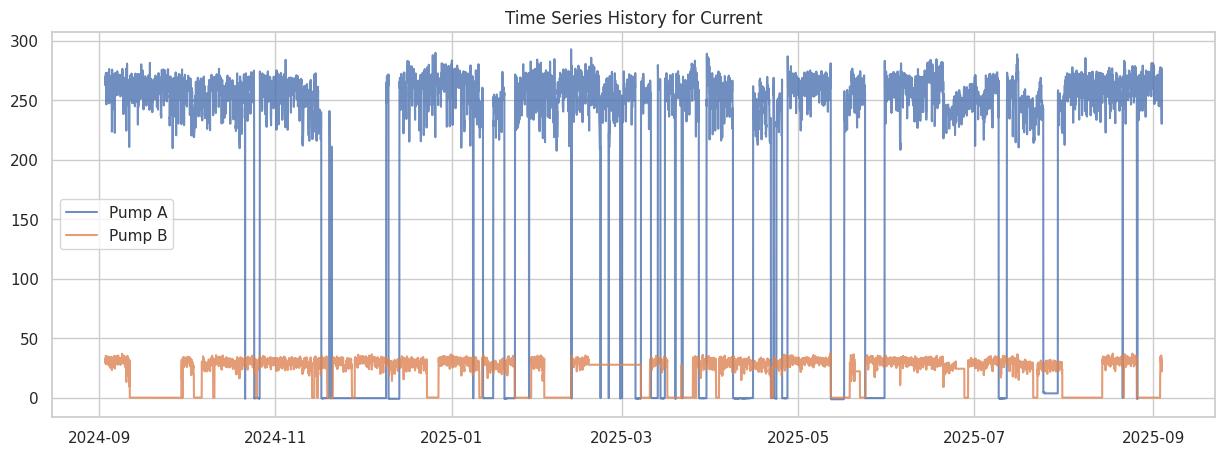

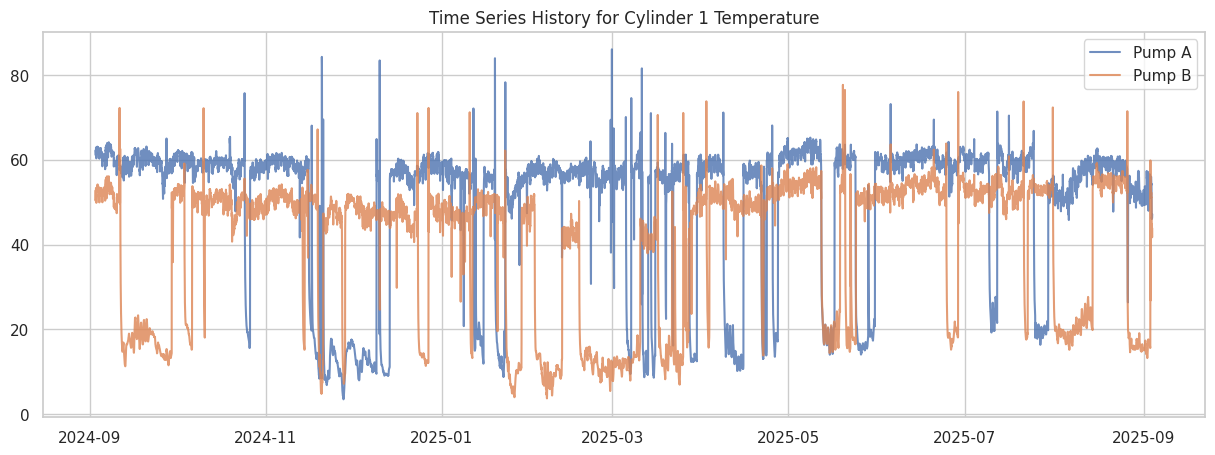

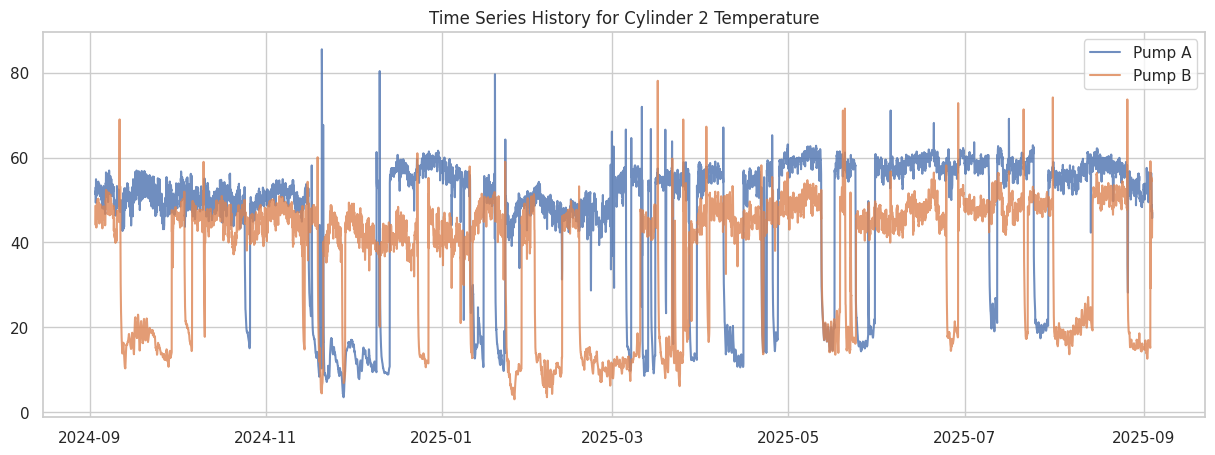

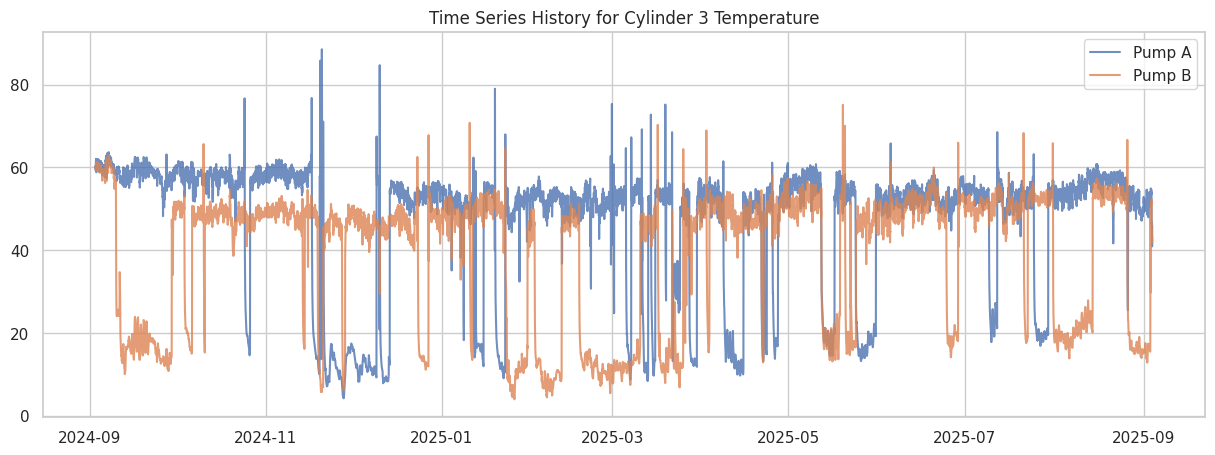

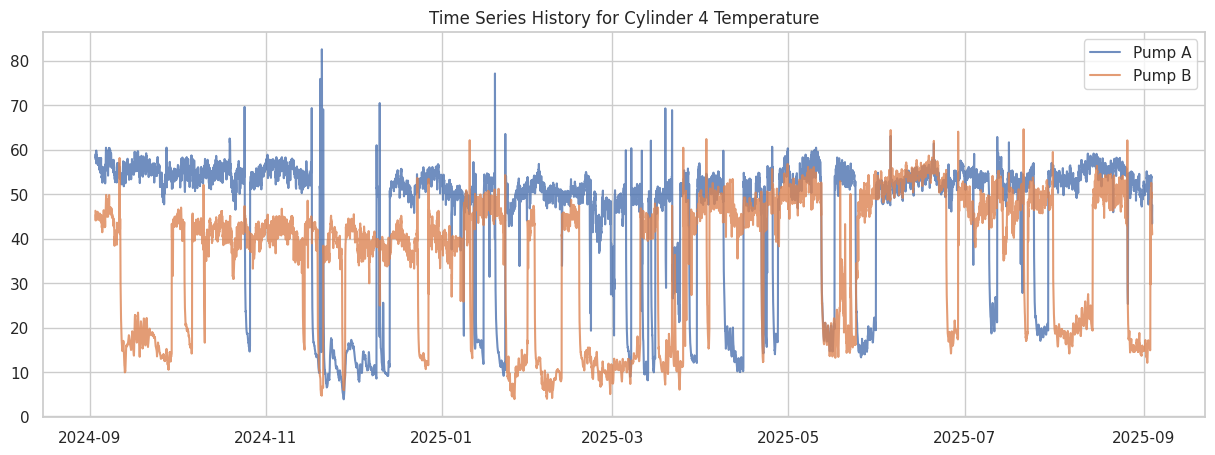

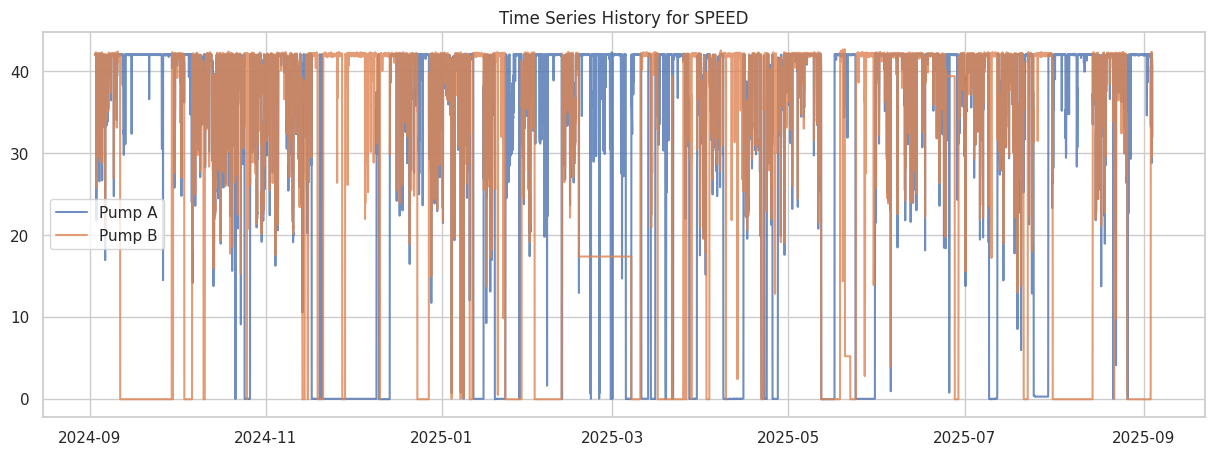

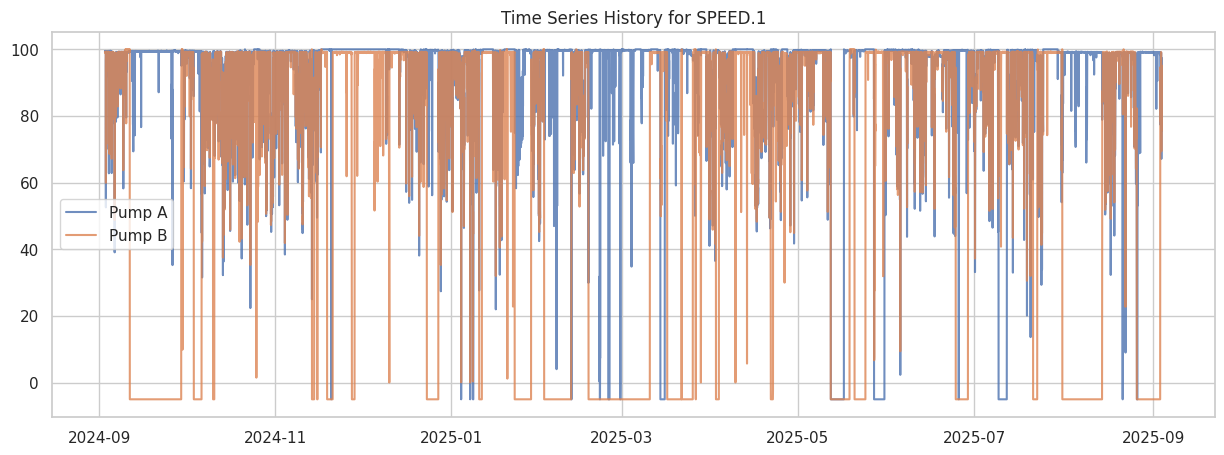

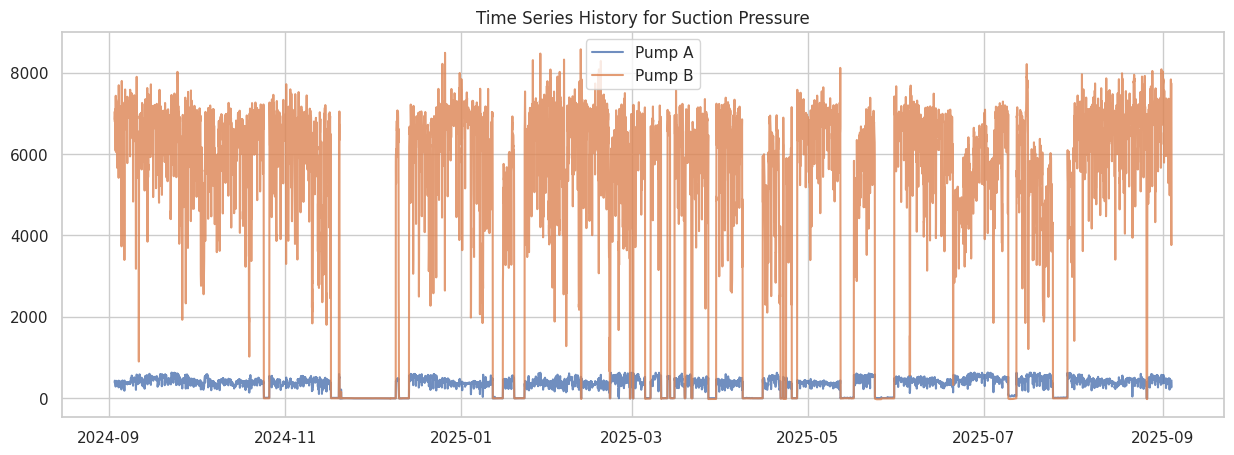

In [16]:
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()
df_a_plt = df_combined[df_combined['Pump'] == 'Pump A'].set_index('Datetime')
df_b_plt = df_combined[df_combined['Pump'] == 'Pump B'].set_index('Datetime')

for col in numeric_cols:
    plt.figure(figsize=(15, 5))
    plt.plot(df_a_plt.index, df_a_plt[col], label='Pump A', alpha=0.8)
    plt.plot(df_b_plt.index, df_b_plt[col], label='Pump B', alpha=0.8)
    plt.title(f'Time Series History for {col}')
    plt.legend()
    plt.show()

## 1.5. Feature Engineering: Rolling Statistics


In [17]:
window_size = 24
df_rolling_features = df_combined.copy()
for col in numeric_cols:
    df_rolling_features[f'{col}_rolling_mean_{window_size}h'] = df_rolling_features.groupby('Pump')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df_rolling_features[f'{col}_rolling_std_{window_size}h'] = df_rolling_features.groupby('Pump')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

df_rolling_features.bfill(inplace=True)
df_rolling_features.ffill(inplace=True) 

df_a_model_ready = df_rolling_features[df_rolling_features['Pump'] == 'Pump A'].copy()
df_b_model_ready = df_rolling_features[df_rolling_features['Pump'] == 'Pump B'].copy()

print("--- Model-Ready DataFrame Head for Pump A (with new features) ---")
df_a_model_ready.head()

--- Model-Ready DataFrame Head for Pump A (with new features) ---


,CYLINDER 3,Current,Cylinder 1 Temperature,Cylinder 2 Temperature,Cylinder 3 Temperature,Cylinder 4 Temperature,Datetime,Pump,SPEED,SPEED.1,Suction Pressure,CYLINDER 3_rolling_mean_24h,CYLINDER 3_rolling_std_24h,Current_rolling_mean_24h,Current_rolling_std_24h,Cylinder 1 Temperature_rolling_mean_24h,Cylinder 1 Temperature_rolling_std_24h,Cylinder 2 Temperature_rolling_mean_24h,Cylinder 2 Temperature_rolling_std_24h,Cylinder 3 Temperature_rolling_mean_24h,Cylinder 3 Temperature_rolling_std_24h,Cylinder 4 Temperature_rolling_mean_24h,Cylinder 4 Temperature_rolling_std_24h,SPEED_rolling_mean_24h,SPEED_rolling_std_24h,SPEED.1_rolling_mean_24h,SPEED.1_rolling_std_24h,Suction Pressure_rolling_mean_24h,Suction Pressure_rolling_std_24h
0,6795.82,262.89,62.21,52.91,59.37,57.87,2024-09-03 00:00:00,Pump A,42.00,99.40,387.84,6795.820000,169.755125,262.890000,3.669884,62.210,0.403051,52.910000,1.110158,59.370,0.268701,57.870000,0.197990,42.000000,0.035355,99.400000,0.056569,387.840000,33.283516
1,7035.89,268.08,61.64,51.34,59.75,58.15,2024-09-03 01:00:00,Pump A,42.05,99.32,434.91,6915.855000,169.755125,265.485000,3.669884,61.925,0.403051,52.125000,1.110158,59.560,0.268701,58.010000,0.197990,42.025000,0.035355,99.360000,0.056569,411.375000,33.283516
2,6843.67,265.45,61.43,52.12,60.37,58.98,2024-09-03 02:00:00,Pump A,41.96,99.47,424.09,6891.793333,127.064128,265.473333,2.595079,61.760,0.403609,52.123333,0.785005,59.830,0.504777,58.333333,0.577264,42.003333,0.045092,99.396667,0.075056,415.613333,24.653329
3,6951.88,270.20,61.10,49.37,59.97,58.11,2024-09-03 03:00:00,Pump A,42.01,99.36,423.87,6906.815000,108.009862,266.655000,3.174109,61.595,0.466369,51.435000,1.518563,59.865,0.418051,58.277500,0.484381,42.005000,0.036968,99.387500,0.063966,417.677500,20.548339
4,6958.68,269.51,61.52,50.28,61.68,58.28,2024-09-03 04:00:00,Pump A,41.95,99.50,425.91,6917.188000,96.372161,267.226000,3.030912,61.580,0.405278,51.204000,1.412915,60.228,0.888774,58.278000,0.419488,41.994000,0.040373,99.410000,0.074833,419.324000,18.172245


# PART 2: Modeling with Random Forest & XGBoost


In [18]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Constants for the modeling part
INPUT_SEQUENCE_LENGTH = 72
PREDICTION_WINDOW = 72

# PART 3: Models for Mud Pump A


### 3.1. Prepare Data for Pump A


In [19]:
TARGET_COL_A = 'Mud Pump A'

# Merge the engineered features with the target column from the cleaned original dataframe
df_merged_a = pd.merge(
    df_a_model_ready,
    df_a_original[['Datetime', TARGET_COL_A]],
    on='Datetime',
    how='inner'
)

# Filter out any 'Error' states from the target column
df_merged_a = df_merged_a[df_merged_a[TARGET_COL_A] != 'Error'].copy()

# Now the rest of the preparation can proceed safely
feature_cols_a = [col for col in df_merged_a.columns if col not in ['Datetime', 'Pump', TARGET_COL_A, 'Mud Pump B']]
feature_values_a = df_merged_a[feature_cols_a].values
status_binary_a = (df_merged_a[TARGET_COL_A] == 'STOP').astype(int).values

X_list_a, y_list_a = [], []
for i in range(INPUT_SEQUENCE_LENGTH, len(feature_values_a) - PREDICTION_WINDOW):
    X_list_a.append(feature_values_a[i - INPUT_SEQUENCE_LENGTH : i].flatten())
    y_list_a.append(status_binary_a[i : i + PREDICTION_WINDOW])

X_a, y_a = np.array(X_list_a), np.array(y_list_a)
print(f"Pump A - X shape: {X_a.shape}, y shape: {y_a.shape}")

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42, shuffle=False)


Pump A - X shape: (8641, 1944), y shape: (8641, 72)


### 3.2. Random Forest for Pump A


--- Training Random Forest for Pump A ---

--- Pump A: Random Forest Classification Report ---
              precision    recall  f1-score   support

     RUN (0)       0.94      0.93      0.94    110376
    STOP (1)       0.51      0.56      0.53     14112

    accuracy                           0.89    124488
   macro avg       0.73      0.74      0.73    124488
weighted avg       0.89      0.89      0.89    124488



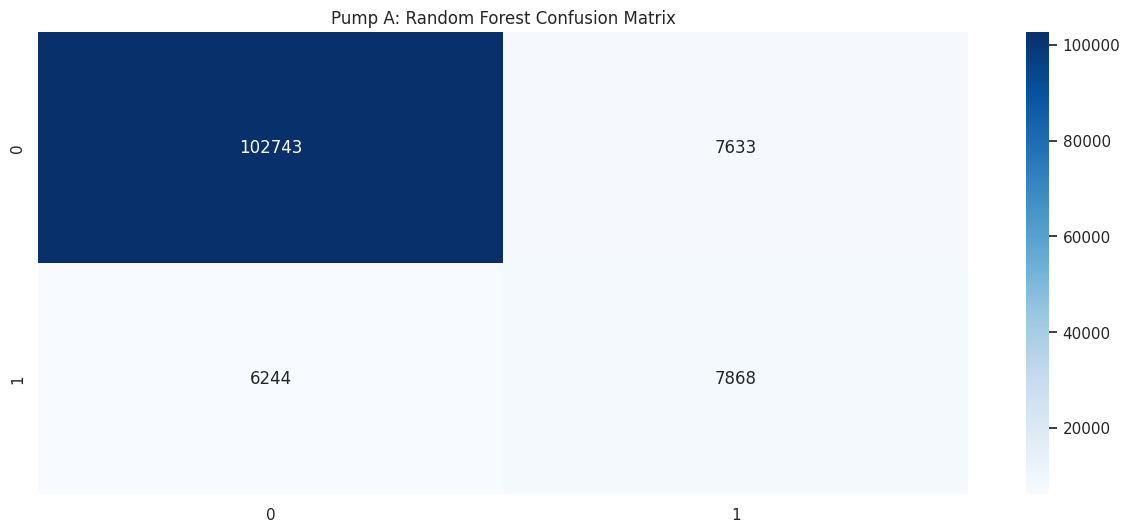

In [20]:
print("--- Training Random Forest for Pump A ---")
rf_a = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1, max_depth=10)
multi_target_rf_a = MultiOutputClassifier(estimator=rf_a, n_jobs=-1)

multi_target_rf_a.fit(X_train_a, y_train_a)
y_pred_rf_a = multi_target_rf_a.predict(X_test_a)

print("\n--- Pump A: Random Forest Classification Report ---")
print(classification_report(y_test_a.flatten(), y_pred_rf_a.flatten(), target_names=['RUN (0)', 'STOP (1)']))

cm_rf_a = confusion_matrix(y_test_a.flatten(), y_pred_rf_a.flatten())
sns.heatmap(cm_rf_a, annot=True, fmt='d', cmap='Blues')
plt.title('Pump A: Random Forest Confusion Matrix')
plt.show()

### 3.3. XGBoost for Pump A


--- Training XGBoost for Pump A ---
Imbalance Ratio (RUN/STOP) for Pump A: 3.29


/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:45:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:45:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:45:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:45:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_labe


--- Pump A: XGBoost Classification Report ---
              precision    recall  f1-score   support

     RUN (0)       0.94      0.92      0.93    110376
    STOP (1)       0.46      0.54      0.50     14112

    accuracy                           0.88    124488
   macro avg       0.70      0.73      0.71    124488
weighted avg       0.89      0.88      0.88    124488



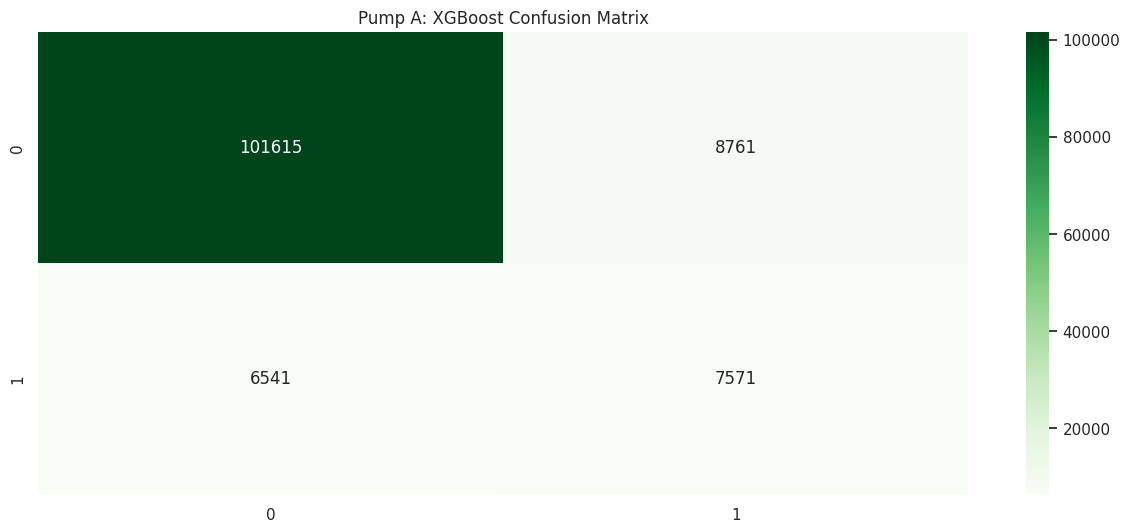

In [21]:
print("--- Training XGBoost for Pump A ---")
num_runs_a = np.sum(y_train_a == 0)
num_stops_a = np.sum(y_train_a == 1)
imbalance_ratio_a = num_runs_a / num_stops_a if num_stops_a > 0 else 1
print(f"Imbalance Ratio (RUN/STOP) for Pump A: {imbalance_ratio_a:.2f}")

xgb_a = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, 
                      scale_pos_weight=imbalance_ratio_a, random_state=42, n_estimators=100, max_depth=5)
multi_target_xgb_a = MultiOutputClassifier(estimator=xgb_a, n_jobs=-1)

multi_target_xgb_a.fit(X_train_a, y_train_a)
y_pred_xgb_a = multi_target_xgb_a.predict(X_test_a)

print("\n--- Pump A: XGBoost Classification Report ---")
print(classification_report(y_test_a.flatten(), y_pred_xgb_a.flatten(), target_names=['RUN (0)', 'STOP (1)']))

cm_xgb_a = confusion_matrix(y_test_a.flatten(), y_pred_xgb_a.flatten())
sns.heatmap(cm_xgb_a, annot=True, fmt='d', cmap='Greens')
plt.title('Pump A: XGBoost Confusion Matrix')
plt.show()



# PART 4: Models for Mud Pump B


### 4.1. Prepare Data for Pump B


In [22]:
TARGET_COL_B = 'Mud Pump B'

# Merge the engineered features with the target column from the cleaned original dataframe
df_merged_b = pd.merge(
    df_b_model_ready,
    df_b_original[['Datetime', TARGET_COL_B]],
    on='Datetime',
    how='inner'
)

# Filter out any 'Error' states from the target column
df_merged_b = df_merged_b[df_merged_b[TARGET_COL_B] != 'Error'].copy()

feature_cols_b = [col for col in df_merged_b.columns if col not in ['Datetime', 'Pump', TARGET_COL_B, 'Mud Pump A']]
feature_values_b = df_merged_b[feature_cols_b].values
status_binary_b = (df_merged_b[TARGET_COL_B] == 'STOP').astype(int).values

X_list_b, y_list_b = [], []
for i in range(INPUT_SEQUENCE_LENGTH, len(feature_values_b) - PREDICTION_WINDOW):
    X_list_b.append(feature_values_b[i - INPUT_SEQUENCE_LENGTH : i].flatten())
    y_list_b.append(status_binary_b[i : i + PREDICTION_WINDOW])

X_b, y_b = np.array(X_list_b), np.array(y_list_b)
print(f"Pump B - X shape: {X_b.shape}, y shape: {y_b.shape}")

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)



Pump B - X shape: (8643, 1944), y shape: (8643, 72)


### 4.2. Random Forest for Pump B


--- Training Random Forest for Pump B ---

--- Pump B: Random Forest Classification Report ---
              precision    recall  f1-score   support

     RUN (0)       0.98      0.99      0.98     86789
    STOP (1)       0.97      0.96      0.96     37699

    accuracy                           0.98    124488
   macro avg       0.97      0.97      0.97    124488
weighted avg       0.98      0.98      0.98    124488



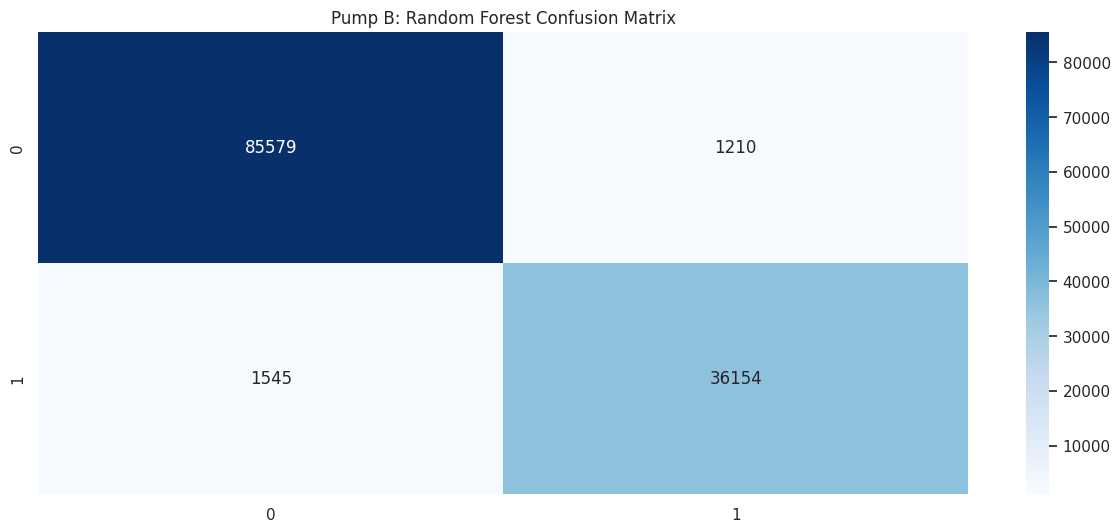

In [23]:
print("--- Training Random Forest for Pump B ---")
rf_b = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1, max_depth=10)
multi_target_rf_b = MultiOutputClassifier(estimator=rf_b, n_jobs=-1)

multi_target_rf_b.fit(X_train_b, y_train_b)
y_pred_rf_b = multi_target_rf_b.predict(X_test_b)

print("\n--- Pump B: Random Forest Classification Report ---")
print(classification_report(y_test_b.flatten(), y_pred_rf_b.flatten(), target_names=['RUN (0)', 'STOP (1)']))

cm_rf_b = confusion_matrix(y_test_b.flatten(), y_pred_rf_b.flatten())
sns.heatmap(cm_rf_b, annot=True, fmt='d', cmap='Blues')
plt.title('Pump B: Random Forest Confusion Matrix')
plt.show()



### 4.3. XGBoost for Pump B


--- Training XGBoost for Pump B ---
Imbalance Ratio (RUN/STOP) for Pump B: 2.11


/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/blackprince/Documents/dev/personal/realta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:50:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_labe


--- Pump B: XGBoost Classification Report ---
              precision    recall  f1-score   support

     RUN (0)       0.99      1.00      0.99     86789
    STOP (1)       0.99      0.99      0.99     37699

    accuracy                           0.99    124488
   macro avg       0.99      0.99      0.99    124488
weighted avg       0.99      0.99      0.99    124488



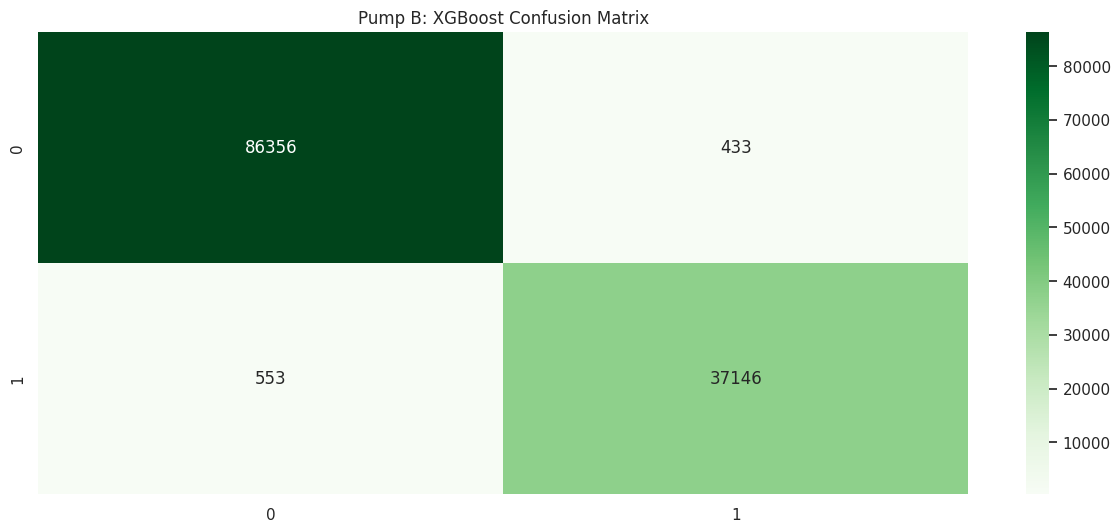

In [24]:
print("--- Training XGBoost for Pump B ---")
num_runs_b = np.sum(y_train_b == 0)
num_stops_b = np.sum(y_train_b == 1)
imbalance_ratio_b = num_runs_b / num_stops_b if num_stops_b > 0 else 1
print(f"Imbalance Ratio (RUN/STOP) for Pump B: {imbalance_ratio_b:.2f}")

xgb_b = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, 
                      scale_pos_weight=imbalance_ratio_b, random_state=42, n_estimators=100, max_depth=5)
multi_target_xgb_b = MultiOutputClassifier(estimator=xgb_b, n_jobs=-1)

multi_target_xgb_b.fit(X_train_b, y_train_b)
y_pred_xgb_b = multi_target_xgb_b.predict(X_test_b)

print("\n--- Pump B: XGBoost Classification Report ---")
print(classification_report(y_test_b.flatten(), y_pred_xgb_b.flatten(), target_names=['RUN (0)', 'STOP (1)']))

cm_xgb_b = confusion_matrix(y_test_b.flatten(), y_pred_xgb_b.flatten())
sns.heatmap(cm_xgb_b, annot=True, fmt='d', cmap='Greens')
plt.title('Pump B: XGBoost Confusion Matrix')
plt.show()

